**Stock Price Prediction using TensorFlow**

**Importing libraries and Dataset**

Python libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.



*   Pandas: This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.

*   Numpy: Nump arrays are very fast and can perform large computations in a very short time


*   Matplotlib/Seaborn: This library is used to draw visualizations.

*   TensorFlow: This is an opensource library that is used for Machine Learning and Artificial Intelligence and provides a range of functions to achieve complex functionalities with single lines of code.







In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

Now let's load the dataset into the pandas dataframe.

In [ ]:
data = pd.read_csv('all_stocks_5yr.csv', delimiter=',', on_bad_lines='skip')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date     open     high     low    close   volume  Name
335927  2017-07-28  101.520  103.360  101.23  103.120  1166817   KSU
181743  2014-02-14   66.100   66.710   65.96   66.370  1050279   DVA
505023  2015-05-26  135.960  136.320  133.34  134.470  1007141   SIG
581320  2018-01-11  112.320  112.810  111.60  112.230   745077  VRSN
492134  2014-03-18   37.465   37.465   36.55   36.625  3032886  ROST
365265  2014-02-03   94.540   94.740   92.91   93.020  6908865   MCD
516058  2014-03-21  161.480  162.140  160.43  161.280  2857219   SPG


Since the given data consists of a data feauture, this is more likely to be an 'object' data type.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


Whenever we deal with the data or time feature, it should always be in the Dateime data type. Pandas library helps us convert the object date feature to the DateTime data type.

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


**Exploratory Data Analysis**

It is a technique that is used to analyze the data through visualoization and manipulation. For this project let us visualize the data of famous companies such as Nvidia, Google, Apple, Facebook and so on.

First let us consider a few companies and visualize the distribution of open and closed Stock prices through 5 years.

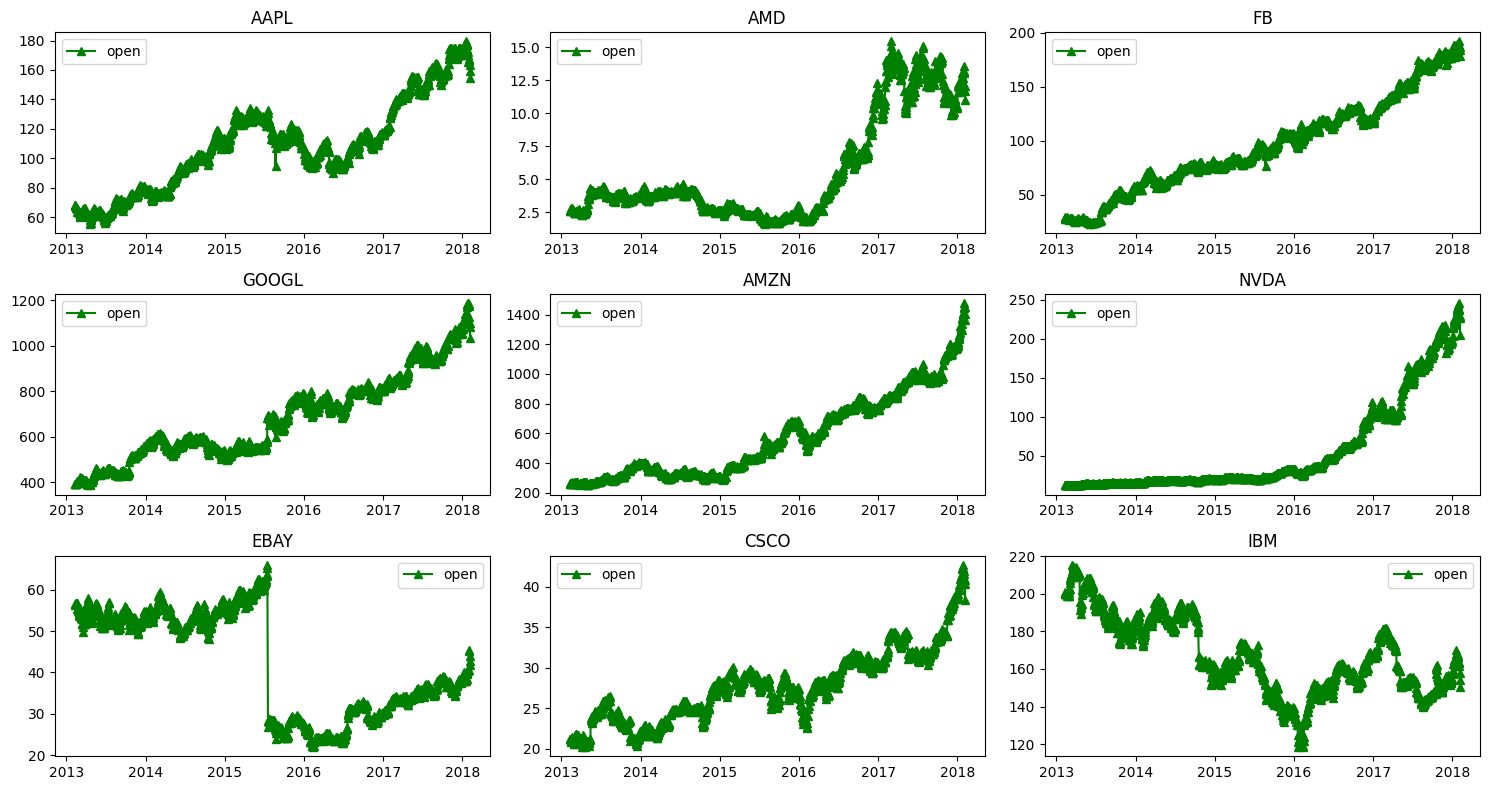

In [ ]:
data['date'] = pd.to_datetime(data['date'])
# date vs open
# date vs close

# Define the list of companies you want to plot
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'AMZN', 'NVDA', 'EBAY', 'CSCO', 'IBM']

plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
  plt.subplot(3, 3, index)
  c = data[data['Name'] == company]
  plt.plot(c['date'], c['open'], c="g", label="open", marker="^")
  plt.title(company)
  plt.legend()
  plt.tight_layout()

Now, let's plot the volume of trade for these 9 stocks as well as a function of time.

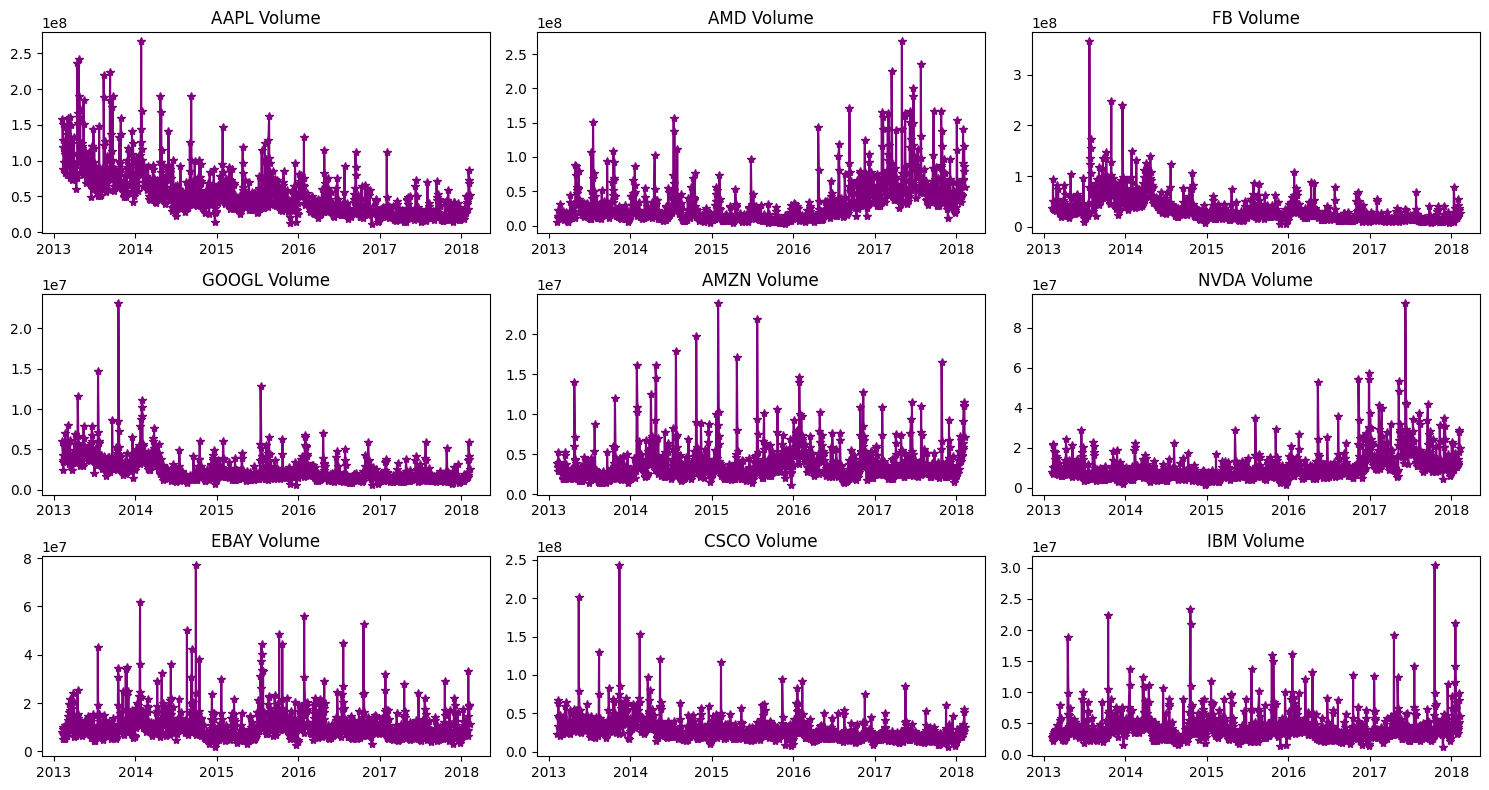

In [ ]:
plt.figure(figsize=(15, 8))
for index, company in enumerate(companies, 1):
  plt.subplot(3, 3, index)
  c = data[data['Name'] == company]
  plt.plot(c['date'], c['volume'], c='purple', marker='*')
  plt.title(f"{company} Volume")
  plt.tight_layout()

Now let's analyze the data for Apple Stocks from 2013 to 2018

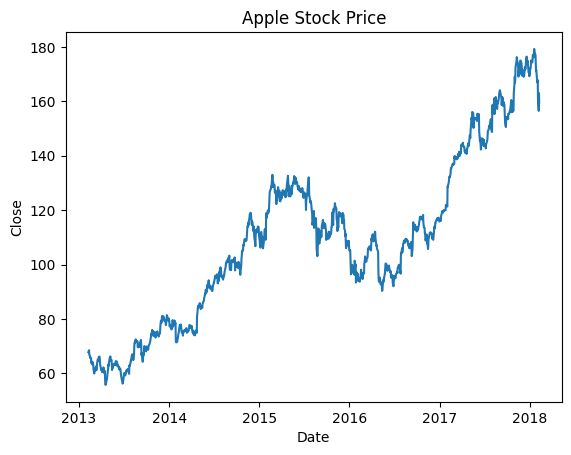

In [ ]:
apple = data[data['Name'] == 'AAPL']
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1))
 & (apple['date']<datetime(2018,1,1))]
plt.plot(apple['date'], apple['close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Price")
plt.show()

Now let's select a subset of the whole data as the training data so that we will be left with a subset of the data for the validation part as well.

In [ ]:
close_data = apple.filter(['close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
print(training)

1197


Now we have the training data length, next applying scaling and preparing features and labels that are x_train and y_train

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-6:i, 0])
  y_train.append(train_data[i, 0])

x_train, t_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


**Build Gated RNN-LSTM network using TensorFlow**

Usinf TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow it is mandatory tp use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units = 64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

<bound method Model.summary of <Sequential name=sequential_1, built=True>>

**Model Compilation and Training**

While compiling a model we provide these three essential parameters:



*   optimizer: This is the method that helps to optimize the cost function by using gradient descent

*   loss: The loss function by which we monitor whether the model is imrpoving with raining or not


*   metrics: This helps to evaluate the model by predicting the training and the validation data






In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import keras

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0]) # Fixed: Changed 6 to 60 to match LSTM lookback
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units = 64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model, converting data to NumPy arrays and handling potential cardinality issues
history = model.fit(np.asarray(x_train), np.asarray(y_train), epochs=10)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0902
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0116
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0083
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0085
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0097
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0070
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0074
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0071
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0066
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0064


For predicting we require testing data, so we first create the testing data and then proceed with the model prediction.

In [ ]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
prediction = model.predict(x_test)
prediction = scaler.inverse_transform(prediction)

# evaluation metrics
# Changed 'predictions' to 'prediction' to use the correct variable name
mse = np.mean(((prediction - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MSE 76.94068090217709
RMSE 8.771583716876735


Now that we have predicted the testing data, let us visualize the dinal results.

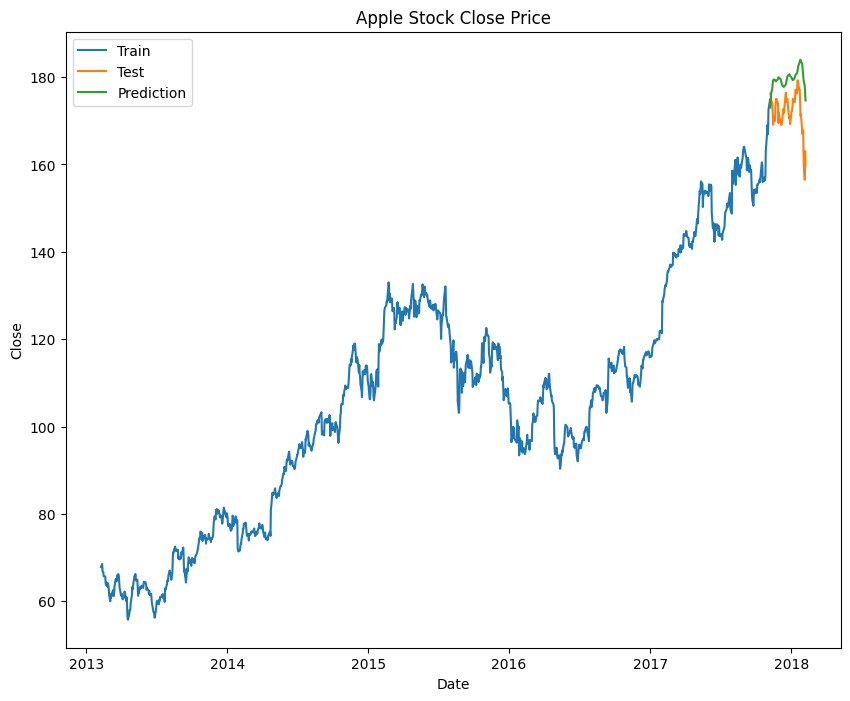

In [ ]:
train = apple[:training]
test =  apple[training:]
test['Prediction'] = prediction

plt.figure(figsize=(10, 8))
plt.plot(train['date'], train['close'])
plt.plot(test['date'], test[['close', 'Prediction']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Prediction'])